# Carrega Bibliotecas

In [42]:
#pip install category_encoders

In [43]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

# Carrega Dataset

In [44]:
stroke_data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [45]:
stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [46]:
stroke_data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [47]:
stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [48]:
stroke_data.nunique().sort_values()

hypertension            2
heart_disease           2
ever_married            2
Residence_type          2
stroke                  2
gender                  3
smoking_status          4
work_type               5
age                   104
bmi                   418
avg_glucose_level    3979
id                   5110
dtype: int64

Se tivéssemos muitas colunas e fôssemos definir um número máximo de valores únicos que determinaria se aquela feature é ou não numérica, uma maneira de selecioná-las seria a seguinte:

```python
features_categoricas = df.loc[:, df.nunique() < N].columns
```

O código acima determina que todas as colunas com menos de N valores únicos são categóricas. De forma análoga, podemos inverter o símbolo e filtrar as colunas numéricas.

In [49]:
stroke_data.loc[:, stroke_data.nunique() < 15].columns

Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status', 'stroke'],
      dtype='object')

In [50]:
# Vamos excluir a coluna id porque não será relevante para a predição
stroke_data = stroke_data.drop('id', axis=1)
stroke_data.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

# Modelo de Machine Learning

In [51]:
stroke_data.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [52]:
features = stroke_data.drop('stroke', axis=1).columns
target = 'stroke'

In [53]:
features

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')

In [54]:
X = stroke_data[features]
y = stroke_data[target]

In [55]:
#Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
#Separando as variáveis numéricas e categóricas. As categóricas serão divididas em binárias e não binárias
#pois vamos aplicar tratamentos diferentes

categorical_features_nb = ['gender', 'work_type', 'Residence_type', 'smoking_status']
categorical_features_b = ['ever_married']
numerical_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

In [57]:
#Fazendo o tratamento nas features

categorical_pipe_TE = Pipeline([
    ('target_encoder', ce.TargetEncoder())
])

categorical_pipe_OE = Pipeline([
    ('ordinal_encoder', ce.OrdinalEncoder())
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

transformer = ColumnTransformer([
    ('categorial_transformer_TE', categorical_pipe_TE, categorical_features_nb),
    ('categorical_transformer_OE', categorical_pipe_OE, categorical_features_b),
    ('numerical_pipe', numerical_pipe, numerical_features)
])

X_train_transformed = transformer.fit_transform(X_train, y_train) #Nesse caso é necessário passar o y_train,
                                                                  #pois o target encoder utiliza o target
X_test_transformed = transformer.transform(X_test)

In [58]:
# Fazendo a predição com o modelo
modelo = RandomForestClassifier()

In [59]:
modelo.fit(X_train_transformed, y_train)

RandomForestClassifier()

In [60]:
y_pred = modelo.predict(X_test_transformed)

In [61]:
#Importando métricas de avaliação

print(f"Acurácia: {accuracy_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"Precisão: {precision_score(y_test, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
print(f"ROC/AUC: {roc_auc_score(y_test, y_pred):.2f}")

Acurácia: 0.94
Recall: 0.00
Precisão: 0.00
F1-Score: 0.00
ROC/AUC: 0.50


C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Como podemos notar, o conjunto de dados está bastante desbalanceado e o modelo caiu em overfitting. Vamos precisar aplicar métodos para balancear nosso conjunto de dados para obter um resultado melhor.

In [62]:
modelo_balanceado = RandomForestClassifier(class_weight='balanced', random_state=42)

In [63]:
modelo_balanceado.fit(X_train_transformed, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [64]:
new_y_pred = modelo_balanceado.predict(X_test_transformed)

In [65]:
print(f"Acurácia: {accuracy_score(y_test, new_y_pred):.2f}")
print(f"Recall: {recall_score(y_test, new_y_pred):.2f}")
print(f"Precisão: {precision_score(y_test, new_y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, new_y_pred):.2f}")
print(f"ROC/AUC: {roc_auc_score(y_test, new_y_pred):.2f}")

Acurácia: 0.94
Recall: 0.02
Precisão: 1.00
F1-Score: 0.03
ROC/AUC: 0.51


Começou a ter uma leve melhora, mas ainda está longe do que esperamos. Vamos então fazer um oversampling considerando que a classe minoritária é bem pequena

In [66]:
stroke_data['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [67]:
#pip install imbalanced-learn

In [68]:
from imblearn.over_sampling import SMOTE

# Crie uma instância do SMOTE
smote = SMOTE(random_state=42)

# Aplique o oversampling ao seu conjunto de dados
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

In [69]:
#Agora vamos treinar nosso modelo novamente
modelo_balanceado.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [70]:
y_pred_after_resampling = modelo_balanceado.predict(X_test_transformed)

In [71]:
print(f"Acurácia: {accuracy_score(y_test, y_pred_after_resampling):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_after_resampling):.2f}")
print(f"Precisão: {precision_score(y_test, y_pred_after_resampling):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_after_resampling):.2f}")
print(f"ROC/AUC: {roc_auc_score(y_test, y_pred_after_resampling):.2f}")

Acurácia: 0.94
Recall: 0.03
Precisão: 0.40
F1-Score: 0.06
ROC/AUC: 0.51


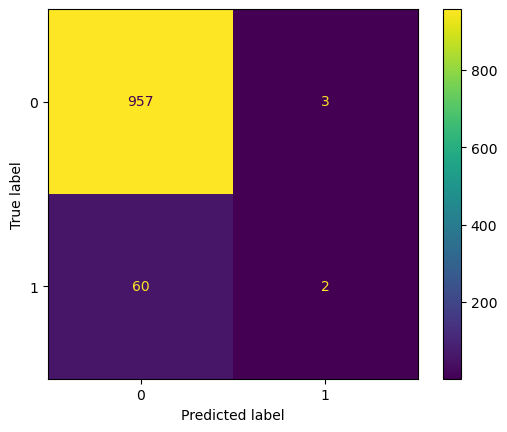

In [72]:
#Visualizando numa matriz de confusão
cm = confusion_matrix(y_test, y_pred_after_resampling, labels=modelo_balanceado.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=modelo_balanceado.classes_)
disp.plot()

### Testando com a Regressão Logística
Vamos testar com um modelo diferente. Tanto com os dados antes do oversampling quanto depois.

In [73]:
# Testando com um modelo diferente 
from sklearn.linear_model import LogisticRegression

modelo_lr = LogisticRegression()
modelo_lr.fit(X_train_transformed, y_train)

C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [74]:
y_pred_lr = modelo_lr.predict(X_test_transformed)

In [75]:
pd.Series(y_pred_lr).value_counts()

0    1022
Name: count, dtype: int64

In [76]:
print(f"Acurácia: {accuracy_score(y_test, y_pred_lr):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.2f}")
print(f"Precisão: {precision_score(y_test, y_pred_lr):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.2f}")
print(f"ROC/AUC: {roc_auc_score(y_test, y_pred_lr):.2f}")

Acurácia: 0.94
Recall: 0.00
Precisão: 0.00
F1-Score: 0.00
ROC/AUC: 0.50


C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
# Agora vamos testar com o oversampling
modelo_lr.fit(X_train_resampled, y_train_resampled)

C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [78]:
y_pred_resampled_lr = modelo_lr.predict(X_test_transformed)

In [79]:
pd.Series(y_pred_resampled_lr).value_counts()

0    739
1    283
Name: count, dtype: int64

In [80]:
print(f"Acurácia: {accuracy_score(y_test, y_pred_resampled_lr):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_resampled_lr):.2f}")
print(f"Precisão: {precision_score(y_test, y_pred_resampled_lr):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_resampled_lr):.2f}")
print(f"ROC/AUC: {roc_auc_score(y_test, y_pred_resampled_lr):.2f}")

Acurácia: 0.75
Recall: 0.76
Precisão: 0.17
F1-Score: 0.27
ROC/AUC: 0.76


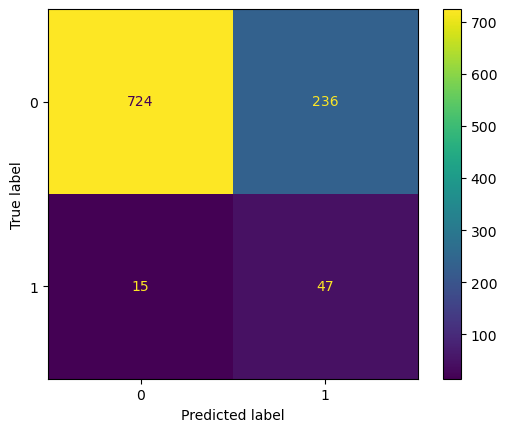

In [81]:
#Visualizando numa matriz de confusão
cm = confusion_matrix(y_test, y_pred_resampled_lr, labels=modelo_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=modelo_lr.classes_)
disp.plot()

Comparando os dois modelos, ambos se saem melhor em alguma métrica e deixam a desejar em outras. Precisamos continuar buscando formas de melhorar e encontrar um modelo que realmente nos traga um bom resultado.